# VAMP

For users already familiar with the VAMP interface: The corresponding [API docs](../api/generated/sktime.decomposition.VAMP.rst#sktime.decomposition.VAMP).

VAMP is short for [V]ariational [A]pproach for [M]arkov [P]rocesses and was introduced in <cite data-cite="wu2020variational">(Wu, 2020)</cite>. It can be used as linear dimensionality reduction tool and extends [TICA](tica.ipynb) in the sense that it gives rise to a systematic way to select input features as well as handles off-equilibrium data consistently.

While the VAMP model possesses methods to project data into lower dimensions, it also is equipped with scoring functions (the so-called VAMP scores), which allow ranking of features. This has been demonstrated in, e.g., <cite data-cite="scherer2019variational">(Scherer, 2019)</cite>.

In [1]:
import numpy as np  # NumPy for general numerical operations
import sktime

In [2]:
ellipsoids = sktime.data.ellipsoids(seed=17)  # create dataset instance
discrete_trajectory = ellipsoids.discrete_trajectory(n_steps=1000)  # discrete transitions
feature_trajectory = ellipsoids.map_discrete_to_observations(discrete_trajectory)  # corresponding observations

In [3]:
vamp = sktime.decomposition.VAMP(
    lagtime=1,  # time shift is one step
    dim=1,  # fix projection dimension explicitly
    scaling=None,
    right=False,
    epsilon=1e-5,
    ncov=5
)

In [4]:
vamp.fit(feature_trajectory)

VAMP-140451494177616:dim=1, epsilon=1e-05, lagtime=1, ncov=5, right=False,
           scaling=None]

In [5]:
model = vamp.fetch_model()

Model contains covariances model (from covariance estimator)

In [6]:
model.cov

CovarianceModel-140451480451200:bessels_correction=False,
                 cov_00=array([[ 5.93356,  5.74457],
       [ 5.74457, 11.81509]]),
                 cov_0t=array([[-0.16118, -0.38952],
       [-0.34175,  5.22138]]),
                 cov_tt=array([[ 5.94527,  5.76567],
       [ 5.76567, 11.84866]]),
                 mean_0=array([-0.17566,  1.93137]),
                 mean_t=array([-0.17295,  1.93458])]

And also gives direct access to c00, c0t, ctt

In [7]:
model.cov_00, model.cov_0t, model.cov_tt

(array([[ 5.93356363,  5.74456963],
        [ 5.74456963, 11.81508652]]),
 array([[-0.16117706, -0.38952488],
        [-0.34174503,  5.22138073]]),
 array([[ 5.94527403,  5.76567464],
        [ 5.76567464, 11.84866097]]))

Cumulative variance

In [8]:
model.cumvar

array([0.99906096, 1.        ])

Dimension parameter of estimator

In [9]:
model.dim

1

Epsilon parameter of estimator

In [10]:
model.epsilon

1e-05

Compute future expectation of observable or covariance using the approximated Koopman operator.

In [16]:
model.expectation  # currently broken

<bound method VAMPModel.expectation of VAMPModel-140451480451248:cov=CovarianceModel-140451480451200:bessels_correction=False,
                 cov_00=array([[ 5.93356,  5.74457],
       [ 5.74457, 11.81509]]),
                 cov_0t=array([[-0.16118, -0.38952],
       [-0.34175,  5.22138]]),
                 cov_tt=array([[ 5.94527,  5.76567],
       [ 5.76567, 11.84866]]),
                 mean_0=array([-0.17566,  1.93137]),
                 mean_t=array([-0.17295,  1.93458])],
              dim=1, epsilon=1e-05, right=False, scaling=None]>

In [17]:
model.mean_0, model.mean_t

(array([-0.17565797,  1.93136925]), array([-0.1729452 ,  1.93458382]))

In [18]:
model.output_dimension

1

In [19]:
model.right

False

In [20]:
model.scaling

In [23]:
model.score(test_model=None, score_method="VAMP2")  # todo: this can be reduced to method="VAMP2"

1.855707696355683

In [24]:
model.singular_values

array([0.9250447 , 0.02836011])

In [25]:
model.singular_vectors_left, model.singular_vectors_right

(array([[ 0.40343037],
        [-0.39956145]]),
 array([[ 0.40050478],
        [-0.39957002]]))

In [26]:
projection = model.transform(feature_trajectory)

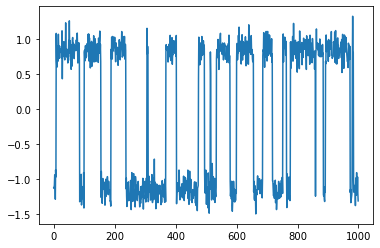

In [27]:
import matplotlib.pyplot as plt
plt.plot(projection)